This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
lower = np.array([1.0])
upper = np.array([2.0])
prior = priors.Uniform(lower, upper)

In [4]:
# we define a few hyper parameters here
n = 50000 # total number of data points for NF
n_sims = n  # total number of points for drawing
n_class = 1 # number of different cosmologies for the training
q_prior = np.linspace(1.4, 1.6, n_sims) #np.random.uniform(0, 1, n)
q_fid = np.asarray([1.5]) #np.random.uniform(0, 1, 1)

In [5]:
q_fid 

array([1.5])

In [6]:
# in order to perform the compressions, we need a few things
n_vec = 50
mu = np.arange(1, n_vec+1)/(q_fid * n_vec)
Cinv = np.arange(1, n_vec+1)*np.eye(n_vec)/ n_vec**2
dmudt = -np.arange(1, n_vec+1)/(q_fid**2 * n_vec)
dmudt = np.reshape(dmudt, [1, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [7]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
d_vec_obs = np.zeros((1, n_vec))
for j in range(1, n_vec+1):
    d_vec_obs[0, j-1] = np.random.gamma(j / q_fid**2, q_fid / n_vec)

# we also create the data for the training
d_vec_q = np.zeros((n_sims, n_vec))
for i, q in enumerate(q_prior):
    for j in range(1, n_vec+1):
        d_vec_q[i, j-1] = np.random.gamma(j / q**2, q / n_vec)
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(50000, 50) (1, 50)


In [8]:
d_vec_obs

array([[0.03559099, 0.01983101, 0.03490612, 0.03440488, 0.06907325,
        0.15977477, 0.14555011, 0.16772586, 0.04848077, 0.07032149,
        0.1622272 , 0.03126455, 0.0707898 , 0.10772593, 0.16167161,
        0.21596894, 0.26370872, 0.18810208, 0.33011933, 0.3122738 ,
        0.21054387, 0.46294313, 0.24800421, 0.46141127, 0.31156241,
        0.29446327, 0.3789111 , 0.31160312, 0.18393915, 0.29392748,
        0.34995036, 0.52674166, 0.49644143, 0.42468701, 0.38473417,
        0.40301001, 0.55638052, 0.57593737, 0.95111182, 0.36955346,
        0.78757869, 0.52306101, 0.33236096, 0.65788097, 0.82000716,
        0.6557485 , 0.58014935, 0.61195148, 0.49553886, 0.85383149]])

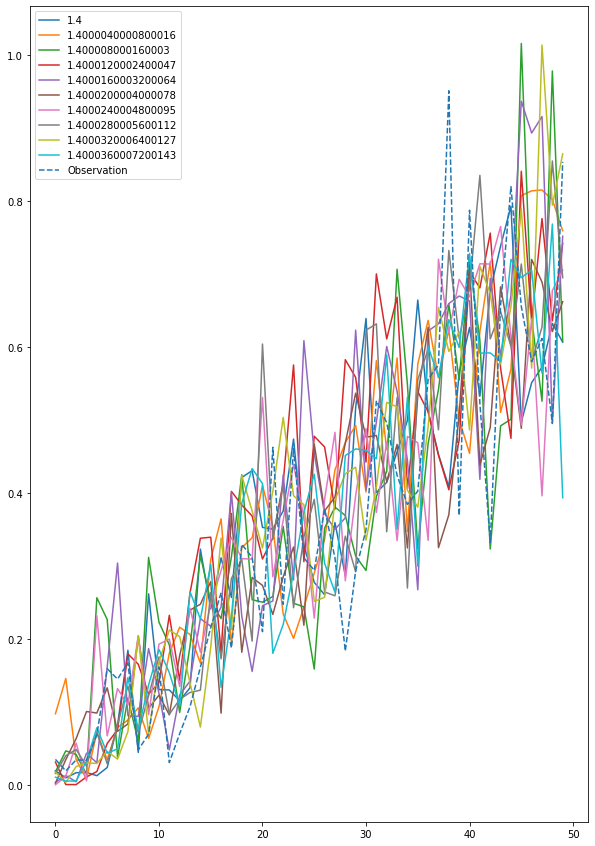

In [9]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(10):
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
#for index in range(n):
#    plt.plot(np.arange(n_vec), d_vec[index],)
plt.plot(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle='--')
plt.legend();

In [10]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec_q[index]))
summaries_noise = np.asarray(summaries_noise)
summary_obs = compressor(d_vec_obs[0])
summary_obs = np.reshape(summary_obs, [1, 1])

In [11]:
compressor(d_vec_obs[0])

array([1.45358817])

In [12]:
compressed_data = summary_obs[0]

sim_params = np.reshape(q_prior, [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs


In [13]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=1, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

## Create DELFI object

In [14]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['q'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [15]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

# Train the networks

In [16]:
DelfiEnsemble.train_ndes()

In [17]:
# this should give us the log-likelihood
n_bins = 10000
posterior_params = np.linspace(1.0, 2.0, n_bins)
sim_params = np.copy(posterior_params)
likelihood_arr = np.zeros((n_bins, 2))
for index, q_value in enumerate(sim_params):
    likelihood_arr[index, :] = q_value, DelfiEnsemble.log_likelihood_stacked(q_value, compressed_data)

In [18]:
likelihood_arr = likelihood_arr[likelihood_arr[:,0].argsort()]
likelihood_arr[:, 1] = np.exp(likelihood_arr[:, 1])
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [19]:
import scipy.special as sps
theo_post = np.zeros((n_bins, 2))
for i, q in enumerate(sim_params):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

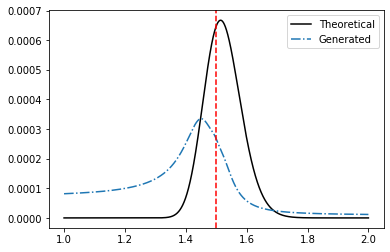

In [20]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid, linestyle='--', color='r')